In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')
sns.set()

In [3]:
hospital_read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 12 columns):
Hospital Name                 16860 non-null object
Provider Number               16860 non-null int64
State                         16860 non-null object
Measure Name                  16860 non-null object
Number of Discharges          16860 non-null object
Footnote                      3129 non-null float64
Excess Readmission Ratio      13731 non-null float64
Predicted Readmission Rate    13731 non-null float64
Expected Readmission Rate     13731 non-null float64
Number of Readmissions        11497 non-null float64
Start Date                    16860 non-null object
End Date                      16860 non-null object
dtypes: float64(5), int64(1), object(6)
memory usage: 1.5+ MB


In [4]:
#Determin rows with nulls
null_columns=hospital_read_df.columns[hospital_read_df.isnull().any()]
hospital_read_df[null_columns].isnull().sum()

Footnote                      13731
Excess Readmission Ratio       3129
Predicted Readmission Rate     3129
Expected Readmission Rate      3129
Number of Readmissions         5363
dtype: int64

In [5]:
hospital_read_df[hospital_read_df.isnull().any(axis=1)].tail(2)

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
16858,GALLUP INDIAN MEDICAL CENTER,320061,NM,READM-30-AMI-HRRP,Not Available,1.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
16859,UNIVERSITY OF LOUISVILLE HOSPITAL,180141,KY,READM-30-HIP-KNEE-HRRP,Not Available,1.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013


In [6]:
hospital_read_df[hospital_read_df['Number of Discharges'] == 'Not Available'].count()

Hospital Name                 5282
Provider Number               5282
State                         5282
Measure Name                  5282
Number of Discharges          5282
Footnote                      3048
Excess Readmission Ratio      2234
Predicted Readmission Rate    2234
Expected Readmission Rate     2234
Number of Readmissions           0
Start Date                    5282
End Date                      5282
dtype: int64

In [7]:
hospital_read_df[hospital_read_df['Number of Discharges'] == 'Not Available'].tail(2)

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
16858,GALLUP INDIAN MEDICAL CENTER,320061,NM,READM-30-AMI-HRRP,Not Available,1.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
16859,UNIVERSITY OF LOUISVILLE HOSPITAL,180141,KY,READM-30-HIP-KNEE-HRRP,Not Available,1.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013


In [8]:
not_avail_xsrat = hospital_read_df[hospital_read_df['Number of Discharges'] == 'Not Available']
not_avail_xsrat['Number of Discharges'][not_avail_xsrat['Excess Readmission Ratio'].isnull()].count()

3048

In [9]:
not_avail_xsrat['Excess Readmission Ratio'][not_avail_xsrat['Number of Discharges']== 'Not Available'].count()

2234

In [10]:
not_avail_xsrat['Number of Discharges'][not_avail_xsrat['Number of Discharges']=='Not Available'].count()

5282

In [11]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:,'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
null_cols=clean_hospital_read_df.columns[clean_hospital_read_df.isnull().any()]
clean_hospital_read_df[null_cols].isnull().sum()

Footnote                      11497
Excess Readmission Ratio         81
Predicted Readmission Rate       81
Expected Readmission Rate        81
Number of Readmissions           81
dtype: int64

In [13]:
clean_hospital_read_df[clean_hospital_read_df.isnull().any(axis=1)].head(2)

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
16857,THREE RIVERS MEDICAL CENTER,180128,KY,READM-30-HIP-KNEE-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
14582,SELLS INDIAN HEALTH SERVICE HOSPITAL,30074,AZ,READM-30-COPD-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013


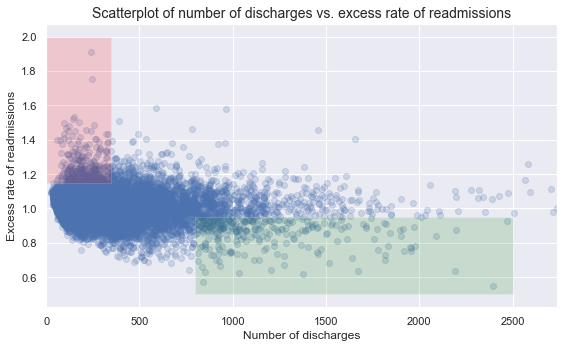

In [14]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

In [15]:
chr_nodles100_avg = clean_hospital_read_df['Excess Readmission Ratio'][clean_hospital_read_df['Number of Discharges'] < 100].mean()
xsrat_grtr1_nodles100 = np.sum(clean_hospital_read_df['Excess Readmission Ratio'][clean_hospital_read_df['Number of Discharges'] < 100]>1)
xsrat_nodles100 = clean_hospital_read_df['Excess Readmission Ratio'][clean_hospital_read_df['Number of Discharges'] < 100].count()

print('The mean of excess readmissions when number of discharges is < 100 is = ',chr_nodles100_avg)
print('\nPercentage of excess readmissions ratios > 1, when number of discharges is < 100 is = ',xsrat_grtr1_nodles100/xsrat_nodles100)
      

The mean of excess readmissions when number of discharges is < 100 is =  1.0226183501683506

Percentage of excess readmissions ratios > 1, when number of discharges is < 100 is =  0.6321548821548821


In [20]:
import os
import requests
import zipfile
import sqlite3
import glob

In [21]:
# Creating an object called staging_dir_name as pointer to Staging
staging_dir_name = "staging4"

In [22]:
# Creating a directory in a local folder
os.mkdir(staging_dir_name)

In [23]:
# Creating a pointer to the given source 
url="https://data.medicare.gov/views/bg9k-emty/files/0a9879e0-3312-4719-a1db-39fd114890f1?content_type=application%2Fzip%3B%20charset%3Dbinary&filename=Hospital_Revised_Flatfiles.zip"

In [ ]:
# Loading the data from URL into new object called r
r = requests.get(url)

In [ ]:
# To know the size of the file in Content-Lenth
r.headers

In [ ]:
#Creating a pointer to zip file  
zip_file_name=os.path.join(staging_dir_name, "Hospital_Revised_Flatfiles.zip")

In [ ]:
# Creating a zip file with write binary format
zf = open(zip_file_name, "wb")

In [ ]:
# Writing the content of URL into the pointer to zip file
zf.write(r.content)

In [ ]:
zf.close()

In [ ]:
z = zipfile.ZipFile(zip_file_name,"r")

In [ ]:
z.extractall(staging_dir_name)

In [ ]:
#Creating a SQLite database in local directory
conn = sqlite3.connect('medicare_hospital_compare3.db')
conn

In [ ]:
#Creating a table for each CSV file
def do_directory(staging_dir_name, conn):
    print("a")
    for filename in glob.glob(os.path.join(staging_dir_name, '*.csv')):
        do_file(filename, conn)
        
def do_file(filename, conn):
        with open(filename) as f:
            with conn:
                data = csv.DicReader(f)
                cols = data.fieldnames
                table=os.path.splitext(os.path.basename(filename))[0]

                sql = 'drop table if exists "{}"'.format(table)
                db.execute(sql)

                sql = 'create table "{table}" ( {cols} )'.format(
                    table=table,
                    cols=','.join('"{}"'.format(col) for col in cols))
                db.execute(sql)

                sql = 'insert into "{table}" values ( {vals} )'.format(
                    table=table,
                    vals=','.join('?' for col in cols))
                db.executemany(sql, (list(map(row.get, cols)) for row in data))

if __name__ == '__main__':
    conn = sqlite3.connect('medicare_hospital_compare3.db')
    do_directory('.', conn)